# Laura_Cavenati_864000_assignment2

## Introduction

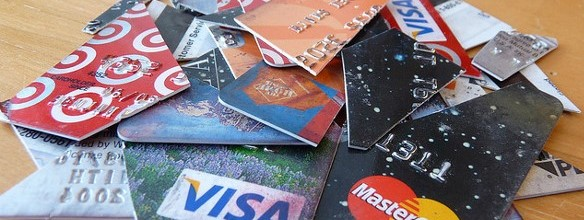

Credit default can defined as the failure to repay a debt including interest or principal on a loan or security on the due date. This can cause losses for lenders so that preventive measures is a must, in which early detection for potential default can be one of those.

The dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.  
The goal of this work is the prediction of default payments using a neural network.  
This case study can be categorized as the binary classification.



## Import Libraries

In [ ]:
import os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score

from keras.callbacks import EarlyStopping
from keras.initializers import GlorotUniform
from keras.utils.generic_utils import get_custom_objects
from keras.utils.generic_utils import get_custom_objects
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Activation
from tensorflow.keras import regularizers
from keras.layers import Dropout
from keras.backend import abs, sum

## Utility functions

In [ ]:
def preprocess_data(X, scaler=None):
    """Preprocess input data by standardise features 
    by removing the mean and scaling to unit variance"""
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler

def draw_histograms(df, variables, n_rows, n_cols, n_bins):
    fig=plt.figure(figsize=(20, 4))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=n_bins,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def binarization(pred, threshold):
  """Evaluation:
  In this classification problem, we evaluate model by looking at how many of 
  their predictions are correct in which the threshold is 50%."""
  p = []
  for i in range(len(pred)):
      if pred[i] > threshold:
          p.append(1)
      else:
          p.append(0)
  return p

## Set folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/MAGISTRALE/2 anno/1 semestre/advanced machine learning')
train_folder = "Assignment 2/"

Mounted at /content/drive


## Import Data

In [ ]:
X_train = pd.read_csv(train_folder+"X_train.csv", index_col='ID')
X_test = pd.read_csv(train_folder+"X_test.csv", index_col='ID')
y_train = pd.read_csv(train_folder+"y_train.csv", index_col='ID')

## Preprocessing of Data

In [ ]:
print('X_train dimension:', X_train.shape)
print('X_test dimension: ', X_test.shape)
X_train.info()  #checking type of every column in the dataset and the presence of null values

X_train dimension: (24000, 23)
X_test dimension:  (6000, 23)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 21754 to 23655
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  24000 non-null  float64
 1   SEX        24000 non-null  int64  
 2   EDUCATION  24000 non-null  int64  
 3   MARRIAGE   24000 non-null  int64  
 4   AGE        24000 non-null  int64  
 5   PAY_0      24000 non-null  int64  
 6   PAY_2      24000 non-null  int64  
 7   PAY_3      24000 non-null  int64  
 8   PAY_4      24000 non-null  int64  
 9   PAY_5      24000 non-null  int64  
 10  PAY_6      24000 non-null  int64  
 11  BILL_AMT1  24000 non-null  float64
 12  BILL_AMT2  24000 non-null  float64
 13  BILL_AMT3  24000 non-null  float64
 14  BILL_AMT4  24000 non-null  float64
 15  BILL_AMT5  24000 non-null  float64
 16  BILL_AMT6  24000 non-null  float64
 17  PAY_AMT1   24000 non-null  float64
 18  PAY_AMT2   24000 non-

This dataset has around 30000 observations in it (24000 in the train set, 6000 in the test set) with 23 columns, all with numeric values. There are no null values.
* ID: ID of each client
* LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit)
* SEX: Gender (1=male, 2=female)
* EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others,
5=unknown, 6=unknown)
* MARRIAGE: Marital status (1=married, 2=single, 3=others)
* AGE: Age in years


* PAY_0: Repayment status in September, 2005 
* PAY_2: Repayment status in August, 2005 
* PAY_3: Repayment status in July, 2005 
* PAY_4: Repayment status in June, 2005 
* PAY_5: Repayment status in May, 2005 
* PAY_6: Repayment status in April, 2005  

scale:-2=no consumption, -1=pay
duly, 0=the use of revolving credit, 1=payment delay for one month,
2=payment delay for two months, ... 8=payment delay for eight
months, 9=payment delay for nine months and above

* BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
* BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
* BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
* BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
* BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
* BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)


* PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
* PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
* PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
* PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
* PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
* PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)


* default.payment.next.month: Default payment (1=yes, 0=no)

Two columns are poorly labeled so I rename them.

In [ ]:
X_train.rename(columns={'PAY_0': 'PAY_1'}, inplace=True)
X_test.rename(columns={'PAY_0': 'PAY_1'}, inplace=True)
y_train.rename(columns={'default.payment.next.month': 'default'}, inplace=True)

## Descriptive, exploratory Analysis and data cleaning

Now we explore the distribution of the data.



### Target variable
The target variable is unbalanced.

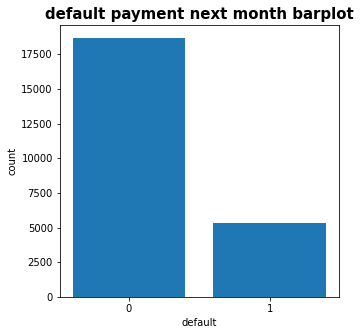

In [ ]:
plt.figure(figsize=(5,5))
plt.title("default payment next month barplot",size=15, weight='bold')
plt.bar(['0', '1'], y_train.groupby(['default']).size())
plt.xlabel('default')
plt.ylabel('count');

In [ ]:
print('The default probability is:', round(y_train['default'].sum() / len(y_train['default'])*100, 2), '%')

The default probability is: 22.18 %


### Categorical variables
The categorical variables are SEX, MARRIAGE, EDUCATION. I want to see both how our dataset is divided and if there are sparse classes which can cause overfit of our models.

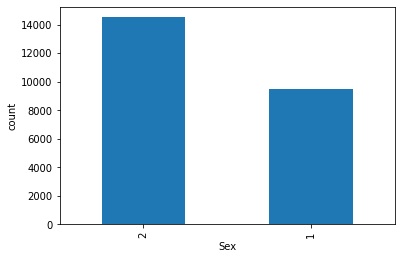

In [ ]:
X_train['SEX'].value_counts().plot(kind='bar')
plt.xlabel('Sex')
plt.ylabel('count');

There are more female than male.

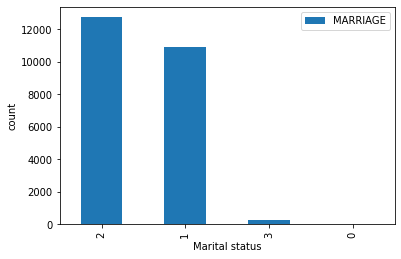

In [ ]:
X_train['MARRIAGE'].value_counts().plot(kind='bar')
plt.xlabel('Marital status')
plt.ylabel('count')
plt.legend();

The undocumented 0 in MARRIAGE can be categorized as 'Other' (thus 3).

In [ ]:
X_train.loc[(X_train.MARRIAGE == 0), 'MARRIAGE'] = 3
X_test.loc[(X_test.MARRIAGE == 0), 'MARRIAGE'] = 3

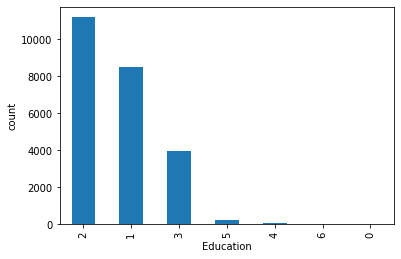

In [ ]:
X_train['EDUCATION'].value_counts().plot(kind='bar')
plt.xlabel('Education')
plt.ylabel('count');

 EDUCATION has category 5 and 6 that are unknown, moreover the category 0 is undocumented. I put them in a same cathegory, category 0.

In [ ]:
X_train.loc[(X_train.EDUCATION == 5) | (X_train.EDUCATION == 6) | (X_train.EDUCATION == 4), 'EDUCATION'] = 0
X_test.loc[(X_train.EDUCATION == 5) | (X_test.EDUCATION == 6) | (X_test.EDUCATION == 4), 'EDUCATION'] = 0

### Numerical variable
I want to use some histograms to have a feel of the distribution, checking if they make sense, the presence of outliers etc...

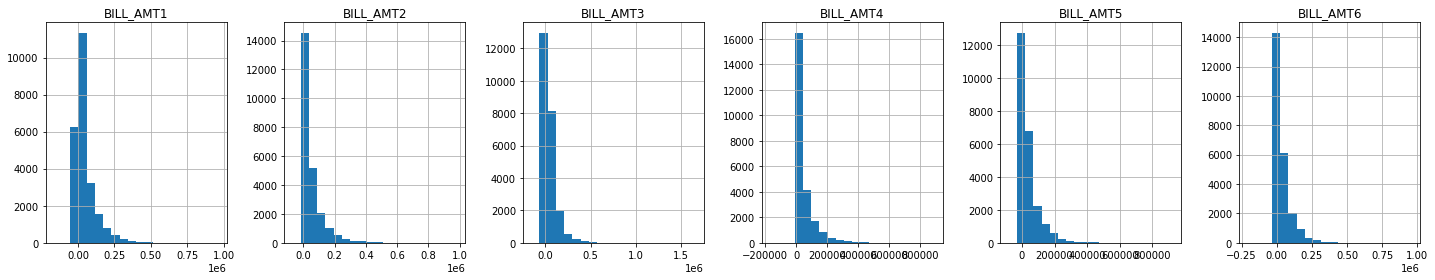

In [ ]:
bills = X_train[['BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']]
draw_histograms(bills, bills.columns, 1, 6, 20)

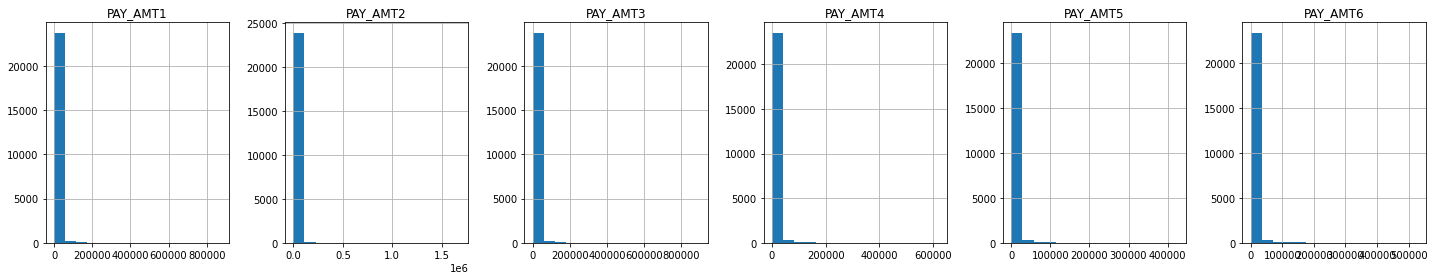

In [ ]:
pay = X_train[['PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]
draw_histograms(pay, pay.columns, 1, 6, 15)

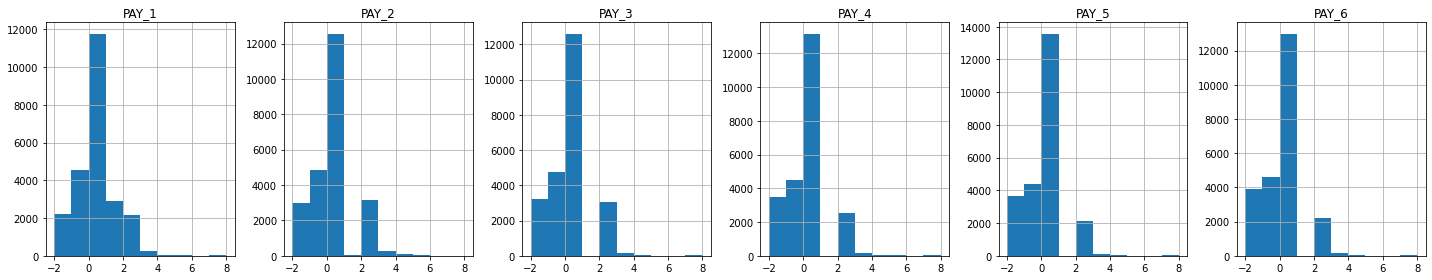

In [ ]:
late = X_train[['PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]
draw_histograms(late, late.columns, 1, 6, 10)

We observe that values 0 for repayment status variables are most of the observations.
As we can see in the graph before, PAY_X with X>1 has almost no payment delay equal to 1. It's very strange! 
I think there is some error in the values of PAY_X.

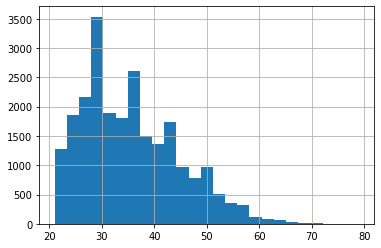

In [ ]:
X_train['AGE'].hist(bins = 25);

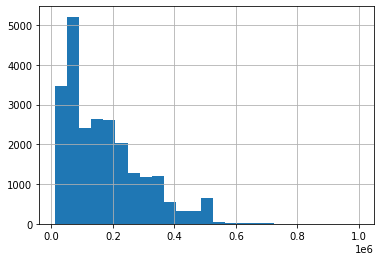

In [ ]:
X_train['LIMIT_BAL'].hist(bins = 25);

### Further analysis
Now I can look at the correlations between the target and the indipendent variables.  
The goal is to see how relevant each feature is and what is its meaning.

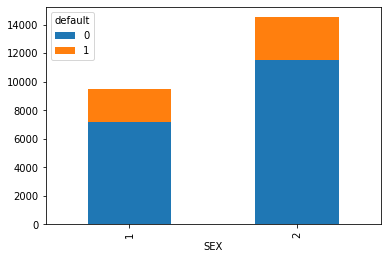

In [ ]:
df_train = X_train.join(y_train)
df_train.groupby(['SEX', 'default']).size().unstack(1).plot(kind='bar', stacked = True);

In [ ]:
df_train[["SEX", "default"]].groupby(['SEX']).mean() #probability for each gender to default 

,default
SEX,
1,0.243936
2,0.207329


There are significantly more women than men and men are most likely going to default the next month.


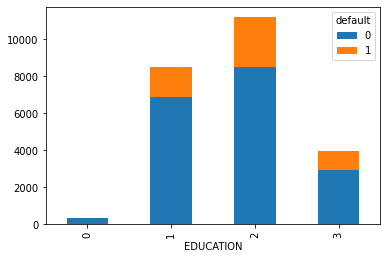

In [ ]:
df_train.groupby(['EDUCATION', 'default']).size().unstack(1).plot(kind='bar', stacked = True);

In [ ]:
df_train[["EDUCATION", "default"]].groupby(['EDUCATION']).mean() #probability to default 

,default
EDUCATION,
0,0.074866
1,0.190661
2,0.239943
3,0.251074


It seems that the higher is the education, the lower is the probability of defaulting the next month.

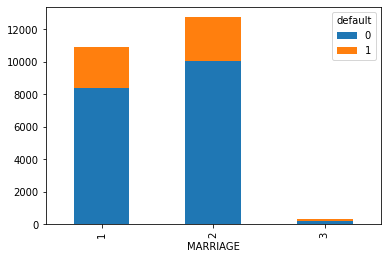

In [ ]:
df_train.groupby(['MARRIAGE', 'default']).size().unstack(1).plot(kind='bar', stacked = True);

In [ ]:
df_train[["MARRIAGE", "default"]].groupby(['MARRIAGE']).mean() #probability to default 

,default
MARRIAGE,
1,0.235149
2,0.210010
3,0.234727


It seems that married people are most likely to default as well as the  category "Other" (which is numerically less relevant than the others).

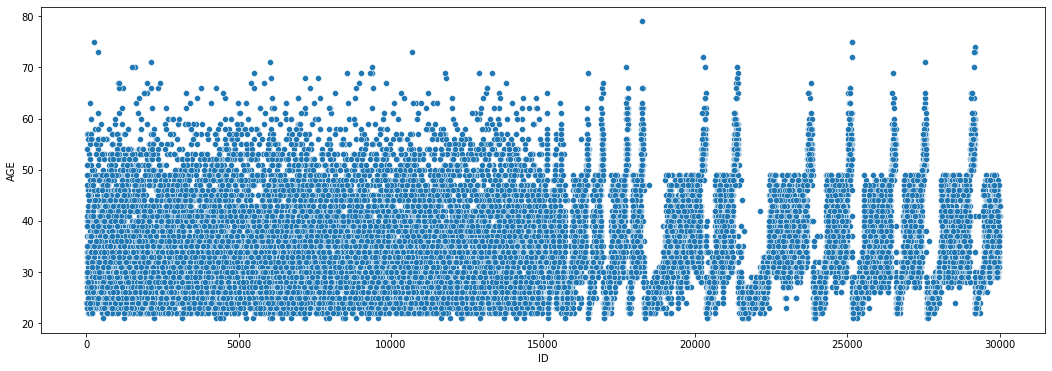

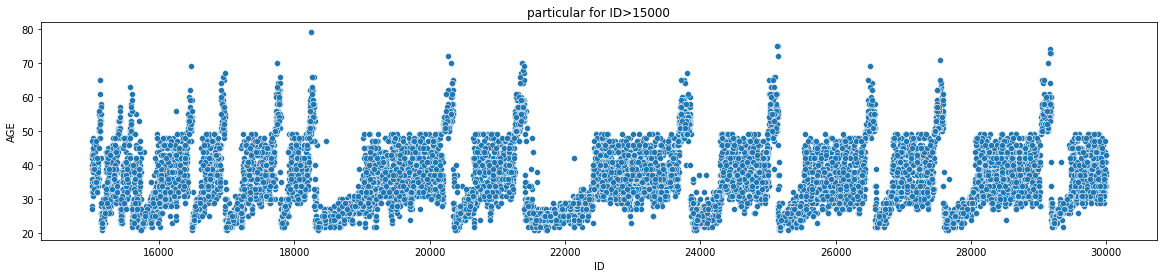

In [ ]:
plt.figure(figsize=(18, 6))
sns.scatterplot(x="ID", y="AGE", data=X_train);

plt.figure(figsize=(20, 4))
sns.scatterplot(x="ID", y="AGE", data=X_train[X_train.index>15000])
plt.title('particular for ID>15000');

ID > 15000 looks strange, may be use different timepoint data.

### STRANGE THINGS
There are certain inconsistencies in the data:  
* There are multiple IDs with PAY_1=2 (or in general > 1) but PAY_1…6=0. See ID 32 (PAY_1=2 but PAY_2=0, which is logically impossible) and ID 90 (PAY_2=2 but PAY_3=0) for an example of this. 

In [ ]:
X_train[(X_train.index==32) | (X_train.index==90)]

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,,,
32,50000.0,1,2,2,33,2,0,0,0,0,0,30518.0,29618.0,22102.0,22734.0,23217.0,23680.0,1718.0,1500.0,1000.0,1000.0,1000.0,716.0
90,20000.0,1,3,2,44,2,2,0,0,0,2,8583.0,8303.0,9651.0,10488.0,12314.0,11970.0,0.0,1651.0,1000.0,2000.0,0.0,1500.0


* There are multiple IDs where BILL_AMT_1 < 0 yet default = 1. See ID 27 for an example of this. 


In [ ]:
df_train[(df_train.index==27)]

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,,,,,,,,,,,,,,,,,,,,,,,,
27,60000.0,1,1,2,27,1,-2,-1,-1,-1,-1,-109.0,-425.0,259.0,-57.0,127.0,-189.0,0.0,1000.0,0.0,500.0,0.0,1000.0,1


* There are multiple IDs with PAY_0…6 all = 0 and BILL_AMT_1…6 all = 0, yet default = 1. A customer did not use credit for the last 6 months and owes nothing. See ID 46 as an example of this.

In [ ]:
df_train[(X_train.index==46) ]

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,,,,,,,,,,,,,,,,,,,,,,,,
46,210000.0,1,1,2,29,-2,-2,-2,-2,-2,-2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


We should ask a domain expert for information on what PAY_X really means.

* For many records the bill amount is greater than the credit limit provided. See ID 6 and ID 16 as an example of this.

In [ ]:
X_train[(X_train.index==6) |(X_train.index==16)]

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,,,
6,50000.0,1,1,2,37,0,0,0,0,0,0,64400.0,57069.0,57608.0,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0
16,50000.0,2,3,3,23,1,2,0,0,0,0,50614.0,29173.0,28116.0,28771.0,29531.0,30211.0,0.0,1500.0,1100.0,1200.0,1300.0,1100.0


# Model Using Keras

I split the dataset in train and validation set.

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

Even if data has not a normal distribution, I standardize data so they have a mean of zero and a standard deviation of
one. (The mean and standard deviation are computed from the training data. The validation and test data have been standardized using the statistics computed from the training data.)

In [ ]:
X_trainst, scaler1 = preprocess_data(X_train)
X_validationst, _ = preprocess_data(X_validation, scaler1)

X_testst, _ = preprocess_data(X_test, scaler1)

### Majority Class Classifier
Majority Class Classifier is an elementary model for prediction. Accuracy will be equal to the fraction of instances belonging to the majority class. In our case, majority class is nondefault or 0. This model achives a level of accuracy of 78%.
But the accuracy measure treats every class as equally important so it isn't a suitable for analyzing imbalaced dataset like ours. f1 measure is a better measure.

In [ ]:
print('Accuracy of majority class classifier:', round(accuracy_score(y_train.values, np.zeros(len(y_train))), 3))
print('f1_measure of majority class classifier:', f1_score(y_train.values, np.zeros(len(y_train))))
print('Confusion matrix of majority class classifier:\n', confusion_matrix(y_train.values, np.zeros(len(y_train))))

Accuracy of majority class classifier: 0.779
f1_measure of majority class classifier: 0.0
Confusion matrix of majority class classifier:
 [[14965     0]
 [ 4235     0]]


### Model 1
Now I built a Neural Network model starting from a simple model with an input layer, one hidden layer and one output layer.  
The number of neurons that make up the input layer equals the number of features in the data, 23.  
Neural Network is a 0/1 classifier so the output layer has a single node.  
As activation function in the input and hidden layer I use ReLU function.  
In the output layer I use a sigmoid output function because values need to be in the range [0, 1].  
I adopt binary_crossentropy as a loss function, adam as optimizer and accuracy as metrics.  
There's a lot of imbalance in the data. So I forces the algorithm to "pay more attention" to samples from an under-represented class, the class 1. class_weight is used for weighting the loss function, only during training.

In [ ]:
n_outputs=y_train.shape[1]
n_input=X_train.shape[1]

a=round(y_train['default'].sum() / len(y_train['default']), 2)  #The default probability
class_weight = {0:a, 1:1-a}

model1 = Sequential()
model1.add(Dense(10, input_shape=(n_input,), activation='relu'))
model1.add(Dense(10, activation='relu'))
model1.add(Dense(n_outputs, activation='sigmoid'))

model1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = ['accuracy'])
result=model1.fit(X_trainst, y_train, batch_size=300, epochs=20, verbose=0,
          validation_data=(X_validationst, y_validation), class_weight=class_weight)

In [ ]:
pred1=model1.predict(X_validationst)
p1=binarization(pred1, 0.5)   #I evaluate 0/1 class using a threshold of 0.5.

In [ ]:
print('Validation accuracy:', round(accuracy_score(y_validation.values, p1), 3))
print('Validation f1_measure:', round(f1_score(y_validation.values, p1), 5))
print('Validation confusion matrix:\n', confusion_matrix(y_validation.values, p1))

Validation accuracy: 0.78
Validation f1_measure: 0.53445
Validation confusion matrix:
 [[3141  571]
 [ 483  605]]


I tried to change some hyperparameters, add other layers to the model, without getting better results in terms of f1 measure.  

Now I investigate the effect of the use of regularization in terms of result and change in the weights of the neural network. 
### Model, with L1 Kernel/Bias regularization (model2)


In [ ]:
initializer = GlorotUniform(seed=1234) 

model2 = Sequential()
model2.add(Dense(10, input_shape=(n_input,), activation='relu', kernel_initializer=initializer, 
                 kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01)))
model2.add(Dense(10,  activation='relu', kernel_initializer=initializer, 
                 kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01)))
model2.add(Dense(n_outputs, activation='sigmoid'))

model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = ['accuracy'])
result2=model2.fit(X_trainst, y_train, batch_size=300, epochs=20, verbose=0,
          validation_data=(X_validationst, y_validation), class_weight=class_weight)

In [ ]:
pred2=model2.predict(X_validationst)
p2=binarization(pred2, 0.5)
print('Validation accuracy:', round(accuracy_score(y_validation.values, p2), 3))
print('Validation f1_measure:', round(f1_score(y_validation.values, p2), 5))

Validation accuracy: 0.796
Validation f1_measure: 0.5255


### Model with L2 Kernel/Bias regularization (model3)

In [ ]:
model3 = Sequential()
model3.add(Dense(10, input_shape=(n_input,), activation='relu', kernel_initializer=initializer, 
                 kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
model3.add(Dense(10,  activation='relu', kernel_initializer=initializer, 
                 kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
model3.add(Dense(n_outputs, activation='sigmoid'))

model3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = ['accuracy'])
result3=model3.fit(X_trainst, y_train, batch_size=300, epochs=20, verbose=0,
          validation_data=(X_validationst, y_validation), class_weight=class_weight)

In [ ]:
pred3=model3.predict(X_validationst)
p3=binarization(pred3, 0.5)
print('Validation accuracy:', round(accuracy_score(y_validation.values, p3), 3))
print('Validation f1_measure:', round(f1_score(y_validation.values, p3), 5))

Validation accuracy: 0.794
Validation f1_measure: 0.53745


The models with L1 and L2 aren't much better in terms of f1 measure than the model without regularization.  
They will be more stable and it is more likely that overfitting will not occur.
### Weight Control
We will analyze how the weights have changed by introducing the penalties in the model.

In [ ]:
print('Layers name:', model1.weights[2].name)
print('Layers kernel shape:', model1.weights[2].shape)
print('Kernel:', model1.weights[2][0], end = '\n\n')
print('Layers name:', model1.weights[3].name)
print('Layers kernel shape:', model1.weights[3].shape)
print('Kernel:', model1.weights[3])

Layers name: dense_1/kernel:0
Layers kernel shape: (10, 10)
Kernel: tf.Tensor(
[-0.2937136   0.08232917  0.24514593  0.4208254   0.09791785 -0.73642415
 -0.11518402  0.4623337  -0.6261193   0.08520631], shape=(10,), dtype=float32)

Layers name: dense_1/bias:0
Layers kernel shape: (10,)
Kernel: <tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float32, numpy=
array([ 0.24999838, -0.11091206, -0.11141913,  0.40989694,  0.1776141 ,
       -0.03409742, -0.14562497, -0.13333975,  0.20416936, -0.18799694],
      dtype=float32)>


In [ ]:
print('Layers name:', model2.weights[2].name)
print('Layers kernel shape:', model2.weights[2].shape)
print('Kernel:', model2.weights[2][0], end = '\n\n')
print('Layers name:', model2.weights[3].name)
print('Layers kernel shape:', model2.weights[3].shape)
print('Kernel:', model2.weights[3])

Layers name: dense_4/kernel:0
Layers kernel shape: (10, 10)
Kernel: tf.Tensor(
[ 0.04979252  0.03262725  0.00149425  0.02474667  0.03707261  0.00028453
  0.03876998  0.00085302  0.02942236 -0.00696888], shape=(10,), dtype=float32)

Layers name: dense_4/bias:0
Layers kernel shape: (10,)
Kernel: <tf.Variable 'dense_4/bias:0' shape=(10,) dtype=float32, numpy=
array([ 0.00054731,  0.00035202,  0.00400497,  0.00108808,  0.00104451,
       -0.0001738 ,  0.00095013,  0.00586298,  0.00035512,  0.05213261],
      dtype=float32)>


In [ ]:
print('Layers name:', model3.weights[2].name)
print('Layers kernel shape:', model3.weights[2].shape)
print('Kernel:', model3.weights[2][0], end = '\n\n')
print('Layers name:', model3.weights[3].name)
print('Layers kernel shape:', model3.weights[3].shape)
print('Kernel:', model3.weights[3])

Layers name: dense_7/kernel:0
Layers kernel shape: (10, 10)
Kernel: tf.Tensor(
[-0.00261323  0.0047891  -0.00363101 -0.00607207 -0.00262861  0.00318381
  0.00928387 -0.00621769  0.00843649  0.00622197], shape=(10,), dtype=float32)

Layers name: dense_7/bias:0
Layers kernel shape: (10,)
Kernel: <tf.Variable 'dense_7/bias:0' shape=(10,) dtype=float32, numpy=
array([0.07010296, 0.0062434 , 0.09916648, 0.16640334, 0.07194036,
       0.00382032, 0.01278285, 0.1691285 , 0.01151237, 0.00811473],
      dtype=float32)>


In [ ]:
print('Sum of the values of the weights without regularization:', sum(abs(model1.weights[2][0])).numpy() + sum(abs(model1.weights[3][0])).numpy())
print('Sum of the values of the weights with regularization l2:', sum(abs(model3.weights[2][0])).numpy() + sum(abs(model3.weights[3][0])).numpy())
print('Sum of the values of the weights with regularization l1:', sum(abs(model2.weights[2][0])).numpy() + sum(abs(model2.weights[3][0])).numpy())

Sum of the values of the weights without regularization: 3.4151978
Sum of the values of the weights with regularization l2: 0.123180784
Sum of the values of the weights with regularization l1: 0.22257939


As we expected, the sum of the weights of the regularized models is lower. In particular the sum of the values of the weights with regularization L1 is less than the sum of the values of the weights with regularization L2.  
```
without reg: [-0.2937136   0.08232917  0.24514593  0.4208254   0.09791785 -0.73642415 -0.11518402  0.4623337  -0.6261193   0.08520631]6]
L1-reg: [0.04979252  0.03262725  0.00149425  0.02474667  0.03707261  0.00028453  0.03876998  0.00085302  0.02942236 -0.00696888]  
L2-reg: [-0.00261323  0.0047891  -0.00363101 -0.00607207 -0.00262861  0.00318381  0.00928387 -0.00621769  0.00843649  0.00622197]
```
We know from the theory that both norms penalize larger weights, L1 tends to create sparse (i.e. lots of 0 weights), L2 tends to like similar weights. 

# Prevision on the test set
We choose the model3 as the best performing model.

In [ ]:
p=model3.predict(X_testst)
np.savetxt('Laura_Cavenati_864000_score2.txt', p3, fmt='%1.1d')
#I can't read this file with txt on my computer because of the encoding.
#I can't open and read it on Colab.

# Comments and conclusion
The models are not able to explain well the variability of the data and default payments.  
This can be due to several reasons:  
- The presence of anomalies in the data (we should consult a domain expert). I trained the model over the data without the anomalous variables (like age) but there is no improvements in f1 measure.
- Optimization of parameters: it would be useful to implement more rigorous methods to optimize the model
- More data may be needed for the network to learn better
- The default may depend on other variables that are not included in the dataset


